In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
import scipy.sparse
import scipy.linalg
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import time

2024-09-19 09:39:18.560908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Inverse Problem
Given parameters of interest (PoI) and observation of a state variable, consider the folowing additive noise model
$$
\textbf{y} = F(\textbf{u}) + \textbf{e}
$$
where $\textbf{u}$ are the PoI, $F$ is the parameter-to-observable(Pto) map and $\textbf{y}$ represent observational data.  

__Goal:__ determine the parameter of interest $\textbf{u}$ given the observational data $\textbf{y}$.  

Solving the inverse problem usually involves solving an optimization problem of the form
$$
\min_{\textbf{u}} \lVert \textbf{y} - F(\textbf{u}) \rVert_{2}^2 + R(\textbf{u})
$$
where $ R(\textbf{u})$ is a regularization term to reduce the size of the solution space, since the problem is usually ill-posed (many possible solution exist that are coherent with our data).  

__Problem:__ the optimization of such functional is computationally expansive.  

__Solution:__ learning a data-driven solver that after an offline training stage (expansive but done only one time), output estimate of our PoI.  

Given as training set  $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$, if we use a neural network $\Psi$ then our solver is paramerized by the weight of the network $\textbf{W}$. This solver require the optimization of the following functional
$$
\min_{\textbf{W}} \frac{1}{M} \sum_{m=1}^M \lVert \textbf{u}^{(m)} - \Psi(\textbf{y}^{(m)}, \textbf{W}) \rVert_{2}^2 + R(\textbf{W})
$$

Instead of regularize the weight of the network directly, we can regularize the output of the network, informing the optimization procedure of the inversion task, of the properties of the noise afflicting our observational data and the knowledge about some physical properties of the PoI we posses. This lead to the following optimization objective
$$
\min_{\textbf{W}} \frac{1}{M} \sum_{m=1}^M \lVert \textbf{u}^{(m)} - \Psi(\textbf{y}^{(m)}, \textbf{W}) \rVert_{2}^2 + \lVert M (\textbf{y} - F(\Psi(\textbf{y}^{(m)}, \textbf{W}))) \rVert_{2}^2 + \lVert P (\Psi(\textbf{y}^{(m)}, \textbf{W})) \rVert_{2}^2
$$
where $M,P$ are some mapping representing information about noise and PoI respectively.

# Bayesian Inverse Problem
By adopting a probabilisitc framework instead of deterministic, the question asked by the inverse problem essentially changes from “what is the value of our parameter?” to “how accurate is the estimate of our parameter?”.   

In this setting, inverse problem deal with the following observational model
$$
    Y = F(U) + E
$$
where $F$ is __Parameter-to-Observable(PtO)__ map and $Y,U,E$ are random variable representing respectively the observational data, the __Parameters of Intereste(PoI)__ and the noise model.  



__Goal:__ model the posterior distribution $P(\textbf{u} | \textbf{y})$, i.e "given the observational data, what is the distribution of the parameters of interest?"

Using Bayes' Theorem
$$
P(\textbf{u} | \textbf{y}) \propto P(\textbf{y} | \textbf{u})P(\textbf{u})
$$
The assumptions usually made are:
- $E \sim N(\mu_E, \Gamma_E)$, $U \sim N(\mu_{pr}, \Gamma_{pr})$, $E\perp U$
- $ P(\textbf{y} | \textbf{u}) = P_E (\textbf{y} - F(\textbf{u}))$


__Problem:__ computing such probability is often intractable.

__Solution:__ using variational inference to approximate such distributions.

Denoting by  $P(\textbf{u} | \textbf{y})$ the target posterior density we want to approximate, __variational inference__ perform such approximation choosing a set of probability distributin $Q_{\phi}(\textbf{u} | \textbf{y})$ parameterized by a parameter $\phi$ and then finiding the distribution in such family "closest" to the target one.  

To do that some notion of distance between $Q_{\phi}(\textbf{u} | \textbf{y})$ and $P(\textbf{u} | \textbf{y})$ must be introduced.  

Normally the Kullback-Leibler divergence (KLD) is used to obtain the evidence lower bound (ELBO), an useful lower bound on the log-likelihood of some observed data, and the goal of variational inference is to minimize the KL divergence, or, equivalently, maximizing the evidence lower bound (ELBO).

Following the work in the reference [1], instead of KLD, a family of Jensen-Shannon Divergence (JSD) is used, leading to the minimization of the following quantity
$$
\frac{1-\alpha}{\alpha} KL(P(\textbf{u} | \textbf{y}) | Q_{\phi}\textbf{u} | \textbf{y})) - \mathbb{E}_{\textbf{u} \sim Q_{\phi}} \left[ \log(P(\textbf{y} | \textbf{u})) \right] + KL(Q_{\phi}(\textbf{u} | \textbf{y}) |P(\textbf{u}))
$$
where $KL(\cdot,\cdot)$ denote the Kullback-Leibler divergence.  

__Objective:__  incorporate such minimization problem into a deep learning framework, i.e recave a differentiable loss function in the form of the one written above in the deterministic setting to train a neural network to perform the variational inference task.

To do so:
- consider a training set  $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$
- apply the fact that the minimization of the KLD between the empirical and model distributions is equivalent to maximization of the likelihood function with respect to $\phi$.
- form a Monte-Carlo estimation using our PoI data
- adopt a Gaussian model for our model posterior $Q_{\phi}(\textbf{u} | \textbf{y}^{(m)})= N(\textbf{u} | \mu_{post}^{(m)}, \Gamma_{post}^{(m)})$
- adopt the Gaussian prior distribution for the noise and the PoI model as assumed above

Detail are in the reference [1].

Considering a neural network $\Psi$ with paramters $\textbf{W}$ that takes as input our observation data $\textbf{y}^{(m)}$ and output the statistics of our approximated posterior model $\phi^{(m)} = (\mu_{post}^{(m)}, \Gamma_{post}^{(m)})$, the following loss function is obtained:
$$
\min_{\textbf{W}} \frac{1}{M} \sum_{m=1}^M \frac{1-\alpha}{\alpha} (\log |\Gamma_{post}^{(m)}| + \lVert \mu_{post}^{(m)}- \textbf{u}^{(m)}) \rVert_{\Gamma_{post}^{(m)-1}}^2
$$

$$
    + \lVert \textbf{y}^{(m)} - F(\textbf{u}_{draw}^{(m)}(\textbf{W})) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2
$$

$$
     + \text{tr}(\Gamma_{pr}^{-1}\Gamma_{post}^{(m)}) +   \lVert \mu_{post}^{(m)}- \mu_{(pr)}) \rVert_{\Gamma_{pr}^{-1}}^2 + \log \frac{\Gamma_{pr}}{\Gamma_{post}^{(m)}}
$$
where
$$
    (\mu_{post}^{(m)}, \Gamma_{post}^{\frac{1}{2}(m)}) = \Psi (\textbf{y}^{(m)}, \textbf{W})
$$

$$
    \textbf{u}_{draw}^{(m)}(\textbf{W}) = \mu_{post}^{(m)} + \Gamma_{post}^{\frac{1}{2}(m)} \epsilon
$$

$$
    \epsilon \sim N(0, \textbf{I}_D)
$$

During the training procedure, the repeated operation of the PtO map on our dataset $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$ may incur a significant computational cost. To alleviate this the PtO map is replaced with another neural network $\Psi_d$ parameterized by weights $\textbf{W}_d$. This is reflected in the following modification of the loss function


$$
     \lVert \textbf{y}^{(m)} - F(\textbf{u}_{draw}^{(m)}(\textbf{W})) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2  \rightarrow \lVert \textbf{y}^{(m)} - \Psi_d(\textbf{u}_{draw}^{(m)}(\textbf{W}), \textbf{W}_d) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2
$$

As exaplained in the paragraph below, our loss function is regularized by the likelihood model containing the PtO map and the prior model containing information on our PoI space.
![](./assets/UQ-VAE.jpeg)

# Appendix

## Poisson Problem
Consider the following modification of Diriclet problem for the poisson equation in two dimension, $\textbf{x} = (x,y) \in \Omega = (0,1)^2$:
$$
\begin{cases}
    - \nabla (q(\textbf{x})\cdot \nabla y(\textbf{x})) = f(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    y(\textbf{x}) = 0 \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
where $q(\textbf{x})$ is the conductivity coefficent, our parameter of interest (with previous notation $\textbf{u} := q(\textbf{x})) $.  

We use a computational grid of dimension $D$, so $\textbf{u} \in R^D$, and $\textbf{y} \in R^O$, with $O$ the dimension of observational data.

## Probabilistic models
As prior model for the parameter of interest we set
$$
P(\textbf{u}) = N(\mu_{pr}, \Gamma_{pr})
$$
with $\mu_{pr} = 2 \textbf{I}_D$ and $\Gamma_{pr} = A^{-2}$ where $A$ is a differential operator such that

$$
Au =  
\begin{cases}
     -\gamma \Delta u + \delta u \;\;\;\;\;\;\;\;\;\;\text{in} \;\; \Omega \\
     \nabla u \cdot \textbf{n} + \beta u \;\;\;\;\;\;\;\;\;\;\text{in}\;\; \partial \Omega
\end{cases}   
$$
with $\gamma = 0.1, \delta = 0.5, \beta = ...$

For the noise model, we set
$$
P(E) = N(\mu_{E}, \Gamma_{E})
$$
with $\mu_{E} = 0 \textbf{I}_O$ and $\Gamma_{E} = \sigma^{2}\textbf{I}_O$ with $\sigma = \eta \max |\textbf{y}|$.

Finally assume a diagonal matrix for the posterior covariance $\Gamma_{post}$. In this way the encoder network output the diagonal of such matrix as a


## Dataset generation
First, we drawn the parameter of interest $\textbf{u} := \textbf{q(\textbf{x})}$ from a Gaussian process (da chiarire se posso usarlo) with mean $\mu = 2$ and covariance

$$
\Gamma_{i,j} = \sigma^2 \exp(- \frac{\lVert \textbf{x}_i - \textbf{x}_j \rVert_2^2 }{2  \rho^2} )
$$
with $\sigma^2$, $\rho = 0.5$.  

Then we generate the corrispondonding observation $\textbf{y}$ using the Poisson solver previusly developed.
We generate in this way both the training set $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$ and test set $\{(\textbf{u}^{(l)}, \textbf{y}^{(l)})\}_{l=1}^L$


## Network architecture
The Encoder network $\Psi$ has:
- 5 hidden layer with 500 units with ReLU activation function  
- an input layer with $O$ number of nodes to match the dimension of our observational data $\textbf{y}$
- an output layer with dimension $2D$ to match the estimate posterior mean $\mu_{post}$ and the diagonal of the posterior covariance $\Gamma_{post}$.  

The decoder network $\Psi_d$ has
- 2 hidden layer with 500 nodes and relu activation function  
- an input layer with $D$ number of nodes to represent a draw from the learned posterior
- an output layer with $O$ nodes to match the dimension of the observational data.
  
For both encoder and decoder no activation function is used in the output layer.  


## Training
For the optimization:
- batch size = 100
- Adam optimizer
- 400 epochs



## Accuracy
The metric used to measure the accuracy on the test set is the averaged relative error
$$
 \frac{1}{L} \sum_{l=1}^L \frac{\lVert \mathbf{y}^{(l)} - \Psi_d(\boldsymbol{\mu}_{\text{post}}(\mathbf{y}^{(l)})) \rVert_2^2}{\lVert  \mathbf{y}^{(l)}\rVert_2^2}
$$
where $\boldsymbol{\mu}_{\text{post}}(\mathbf{y}^{(l)})$ is the estimated posterior mean fron the encoder network $\Psi$ taking a datapoint $\mathbf{y}^{(l)}$ as input.

# Implementation

We set the domain [0,1]x[0,1] and the number of refinements.
In our case n = 4 means that each side of the domain will be split in half 4 times, resulting in 2^4 = 16 segments (and 17 points) for each side.
Hence, our grid will be composed of (2^n+1)^2, i.e. 17x17=289, points.

In [2]:
# Domain
a = -2
b = 2
c = -2
d = 2

# Number of refinement
n = 4;

# Number of discretization node on x and y axis n_x and n_y, dimension of PoI u D
n_x = n_y = 2**n+1

N = D = n_x*n_y

# Dimension of obs data y
O = 75

x = np.linspace(a, b, n_x)
y = np.linspace(c, d, n_y)
xv, yv = np.meshgrid(x, y)

## Noise model

For the moment we have not implemented the noise yet

In [3]:
noise_mean = np.zeros(O)

#diagonal of noise covariance
sigma = 0.05
noise_cov = sigma*np.ones(O)

# TODO add noise to the observation

## PoI model

Here we create the normal distribution for the sampling of the diffusion coefficient (our PoI). The coefficient is defined over (2^n+1)^2 = 289 points, so the mean will be a 289-dimensional vector, and the covariance will be a 289x289 matrix.

Mean: $$ \mu_i = 2 \quad \forall i = 1,...,289 $$
Covariance: $$ \Gamma_{i,j} = \sigma^2 \exp(- \frac{\lVert \textbf{x}_i - \textbf{x}_j \rVert_2^2 }{2  \rho^2} ) \quad \forall i,j= 1,...,289 $$

In [4]:
grid = np.c_[yv.ravel(), xv.ravel()]

In [5]:
def covariance(x_i,x_j):
    sigma = 0.5;
    rho = 0.5;
    return sigma**2*np.exp(-np.linalg.norm(x_i - x_j)**2 / (2*rho**2))

In [6]:
mean = 2*np.ones(D)
Cov = np.zeros((D, D))

In [7]:
for i in np.arange(N):
    for j in np.arange(N):
        Cov[i,j] = covariance(grid[i], grid[j])

In [8]:
np.linalg.eigvals(Cov).min()

(1.1088063976861833e-13+0j)

To avoid bad conditioning we add a small value $\epsilon$ to all the diagonal elements of the matrix

In [124]:
Cov.dtype

dtype('float64')

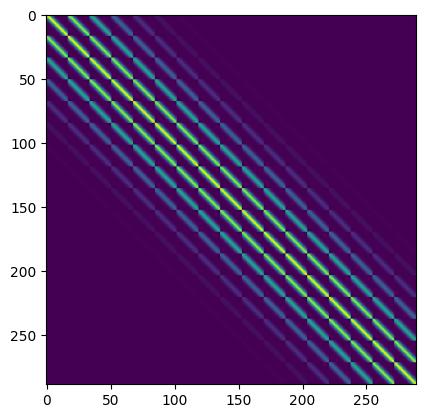

In [9]:
plt.imshow(Cov)

## PoI generation (diffusion coefficents)

Here we generate 500 random coefficient grids sampling from the normal distribution created above. Each of the 500 samplings will be a vector containing the values of the coefficient over the 289 points of the grid.
All the data is exported in a text file, in order to be processed in Matlab.
Then we visualize some of the coefficient values on the 17x17 grid and in a cross sectional view over a line (in red)

In [40]:
q_data = np.random.multivariate_normal(mean, Cov, size = 500)
q_data.shape
q_data.min()
# TODO scartare sample negativi : DONE

0.0954909905480068

In [51]:
# Delete negative samples
#q_data_pos = []
# Identify rows where all elements are positive
positive_rows = q_data[(q_data > 0).all(axis=1)]
positive_rows.shape

(500, 81)

In [10]:
# Save the matrix to a text file
#np.savetxt('./test_data/q_file_nref4_75.txt', q_data)

# Load the data
q_data = np.loadtxt('./test_data/q_file_nref4.txt')

In [12]:
q_data.shape

(500, 289)

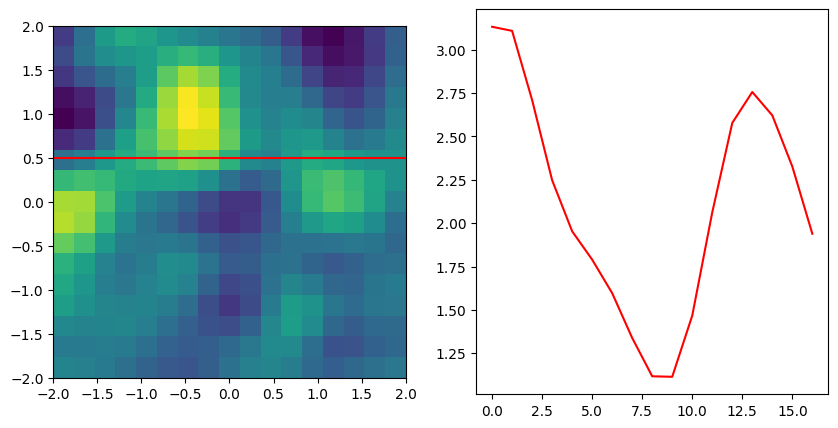

In [11]:
# PoI visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(q_data[0].reshape(n_x, n_y), extent=(a, b, c, d))

# Cross sectional view along the red line
axs[0].axhline(y = 0.5, color = 'r', linestyle = '-')
axs[1].plot(q_data[0].reshape(n_x, n_y)[8, :], color="red")

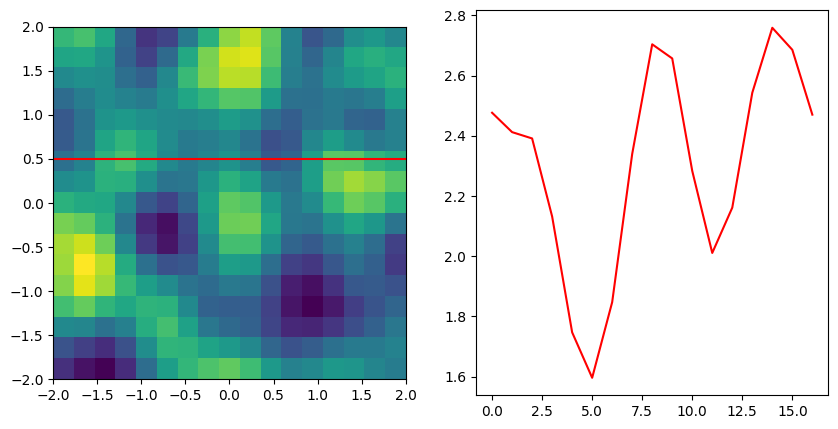

In [14]:
# PoI visualization
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(q_data[1].reshape(n_x, n_y), extent=(a, b, c, d))

# Cross sectional view along the red line
axs[0].axhline(y = 0.5, color = 'r', linestyle = '-')
axs[1].plot(q_data[1].reshape(n_x, n_y)[8, :], color="red")

In [12]:
print(q_data.max())
print(q_data.min())
# all values are between 0 and 4

3.9994161021206516
0.09684811625543754


## Observable variables (solutions from FEM solver)

The Poisson problem:
$$
\begin{cases}
    - \nabla (q(\textbf{x})\cdot \nabla y(\textbf{x})) = f(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    y(\textbf{x}) = 0 \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
with $ f = e^{x+y}[y(1-y)(1+2x) + x(1-x)(1+2y)] $

is solved through a Matlab FEM solver for each of the 500 coefficient samplings. This gives us the solution y of the problem, which represents our observable parameter (Remember: the final goal is to observe y and make estimates on q). The data from Matlab is imported with a text file, which contains the 500 solutions (one for every coefficient sampling). Each solution is a vector with 289 elements (if necessary, the solver allows to vary this number, the grid does not have to be the same as the one used for the coefficient q).
Then we represent some of the solutions with different plots.
After this, all the values of y are normalized in order to have values between -1 and 1.

In [13]:
# Loading from FEM solver developed in matlab
y_data = np.loadtxt('./test_data/uh_file_nref4.txt')
y_data.shape

(500, 289)

In [18]:
y_data[0]

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.864868,  1.732961,  2.703697,  3.579118,  3.895467,  3.801834,
        3.613522,  3.470278,  3.406913,  3.398042,  3.362561,  3.202778,
        2.857511,  2.250067,  1.288339,  0.      ,  0.      ,  1.543703,
        3.140367,  4.828126,  6.227359,  6.90493 ,  7.028726,  6.933762,
        6.846224,  6.864532,  6.949795,  6.920872,  6.564328,  5.777863,
        4.482984,  2.564392,  0.      ,  0.      ,  2.182009,  4.39924 ,
        6.521813,  8.187012,  9.221718,  9.767488, 10.04323 , 10.250365,
       10.515865, 10.765161, 10.701387, 10.036019,  8.699124,  6.679053,
        3.8349  ,  0.      ,  0.      ,  2.848101,  5.532709,  7.880883,
        9.743667, 11.12613 , 12.132983, 12.898359, 13.556495, 14.159673,
       14.519128, 14.309665, 13.315812, 11.488921, 

In [14]:
#normalization of y
y_a = y_data.min()
y_b = y_data.max()
y_data_norm = (y_data - (y_b+y_a)/2) / ((y_b-y_a)/2)  #now it's in (-1,1)
y_data_norm.shape

# TODO: normalizzare anche i q -> modifica anche la distribuzione
q_a = q_data.min()
q_b = q_data.max()
q_data_norm = (q_data - (q_b+q_a)/2) / ((q_b-q_a)/2)  #now it's in (-1,1)
q_data_norm.shape

(500, 289)

In [65]:
scaling_factor = (q_b-q_a)/2
scaling_factor_y = (y_b-y_a)/2

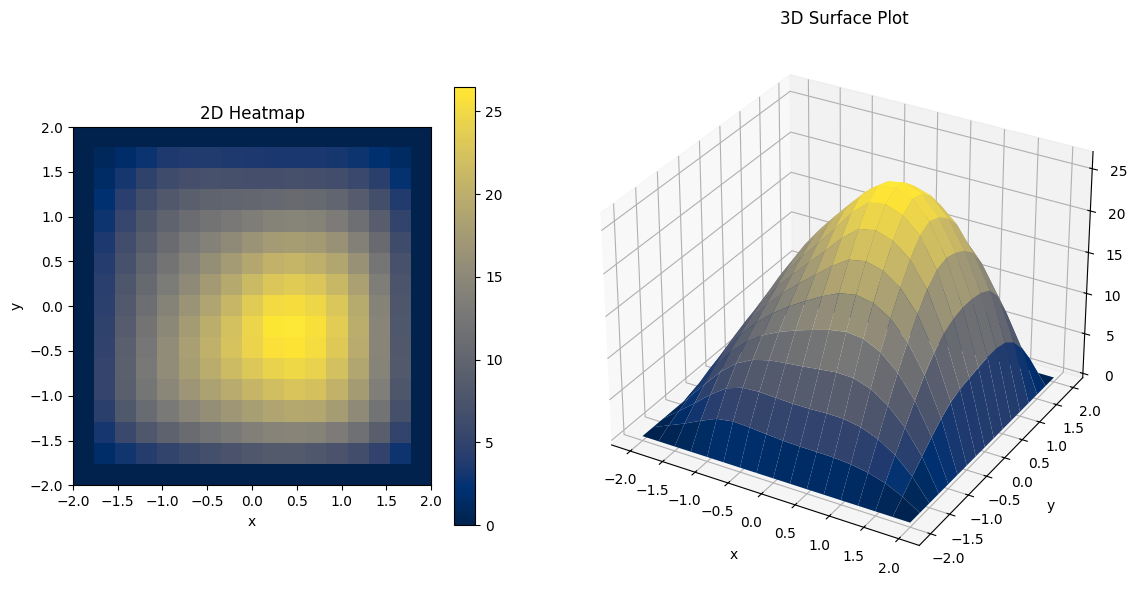

In [20]:
# plot the exact solution
z = y_data[0].reshape(n_x,n_y)

# Set up the figure and GridSpec
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1.5])

# Plot the 2D heatmap
ax0 = fig.add_subplot(gs[0])
im = ax0.imshow(z, extent=(a, b, c, d), cmap='cividis')
ax0.set_title('2D Heatmap')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
fig.colorbar(im, ax=ax0, shrink=0.8)

# Plot the 3D surface plot
ax1 = fig.add_subplot(gs[1], projection='3d')
ax1.plot_surface(xv, yv, z, cmap='cividis')
ax1.set_title('3D Surface Plot')
ax1.set_xlabel('x', labelpad=10)
ax1.set_ylabel('y', labelpad=10)
ax1.set_zlabel('z', labelpad=10)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

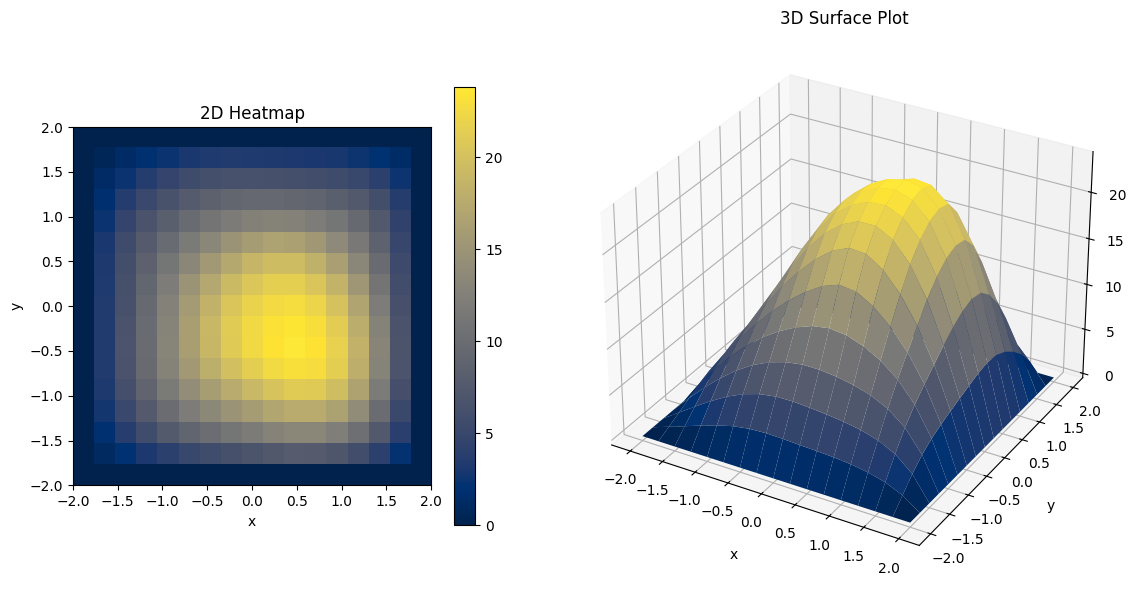

In [21]:
# plot the exact solution
z = y_data[1].reshape(n_x,n_y)

# Set up the figure and GridSpec
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1.5])

# Plot the 2D heatmap
ax0 = fig.add_subplot(gs[0])
im = ax0.imshow(z, extent=(a, b, c, d), cmap='cividis')
ax0.set_title('2D Heatmap')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
fig.colorbar(im, ax=ax0, shrink=0.8)

# Plot the 3D surface plot
ax1 = fig.add_subplot(gs[1], projection='3d')
ax1.plot_surface(xv, yv, z, cmap='cividis')
ax1.set_title('3D Surface Plot')
ax1.set_xlabel('x', labelpad=10)
ax1.set_ylabel('y', labelpad=10)
ax1.set_zlabel('z', labelpad=10)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [63]:
y_data_norm[1] - y_data_norm[70]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.03016012, -0.06063322, -0.06628113, -0.04405938, -0.01792535,
       -0.00270303,  0.01173684,  0.        ,  0.        , -0.03677543,
       -0.09008202, -0.10857643, -0.11186274, -0.12140871, -0.0768514 ,
        0.00507885,  0.        ,  0.        , -0.00459515, -0.07616853,
       -0.11349879, -0.1174822 , -0.11958772, -0.06541331, -0.00324364,
        0.        ,  0.        ,  0.00739777, -0.07244119, -0.10117866,
       -0.07231315, -0.05586735, -0.06013529, -0.04262251,  0.        ,
        0.        ,  0.01675878, -0.0413279 , -0.07198594, -0.05649332,
       -0.05571086, -0.08801918, -0.06781759,  0.        ,  0.        ,
        0.02782698, -0.01213518, -0.04808547, -0.05204043, -0.05710506,
       -0.07279685, -0.03538123,  0.        ,  0.        ,  0.02216484,
       -0.00742622, -0.02768471, -0.03717377, -0.0502479 , -0.04

### Sample random observations point

Here we choose 10 random points where the observable variable y will be observed. We can think at them as the point where we put some instruments to measure the data y.
The variable observed_data will then contain, for each of the 500 samplings, the 10 values of y observed in the points.

In [16]:
O = 75

# Set Gaussian distribution parameters
mean_x, mean_y = n_x // 2, n_y // 2  # Center the mean in the middle of the grid
std_x, std_y = n_x / 6, n_y / 6      # Set standard deviations to control spread

# Border margin (exclude points near the edge, e.g., margin of 5)
border_margin = 5

# Draw O points from Gaussian distributions for both X and Y dimensions
gaussian_x = np.random.normal(mean_x, std_x, 4*O).astype(int)
gaussian_x
gaussian_y = np.random.normal(mean_y, std_y, 4*O).astype(int)

gaussian_x = gaussian_x[(gaussian_x > 0) & (gaussian_x < n_x-1)]
gaussian_y = gaussian_y[(gaussian_y > 0) & (gaussian_y < n_y-1)]

gaussian_x = gaussian_x[0:3*O]
gaussian_y = gaussian_y[0:3*O]
# Clip values to exclude the border points
#gaussian_x = np.clip(gaussian_x, border_margin, n_x - border_margin - 1)
#gaussian_y = np.clip(gaussian_y, border_margin, n_y - border_margin - 1)

# Sample points from the grid using Gaussian-distributed indices
# Use the grid to map Gaussian-distributed points
# Flatten the 2D Gaussian coordinates to match grid indices
obs_indices = gaussian_y * n_x + gaussian_x  # Index calculation for flattened grid
obs_indices = np.unique(obs_indices)
obs_indices = np.random.choice(obs_indices, size=O, replace=False)
obs_points = grid[obs_indices]


#obs_points = np.unique(obs_points, axis=0)
obs_points

array([[-0.25, -0.75],
       [-0.5 ,  0.  ],
       [-0.25, -1.75],
       [ 1.  ,  0.75],
       [ 0.25,  0.75],
       [ 0.  ,  0.5 ],
       [ 1.25,  0.75],
       [ 0.75,  0.  ],
       [ 0.  ,  0.25],
       [-0.75, -0.75],
       [-0.25, -1.5 ],
       [ 0.75,  1.  ],
       [-0.75,  1.25],
       [ 1.25, -1.75],
       [-1.5 ,  0.25],
       [ 0.75,  0.25],
       [ 0.25, -1.25],
       [-0.5 , -0.25],
       [ 0.  , -0.5 ],
       [ 0.  , -1.25],
       [ 1.  , -0.5 ],
       [-0.25,  1.  ],
       [-1.75, -0.25],
       [-1.5 , -0.25],
       [ 0.25,  0.5 ],
       [-1.5 ,  0.75],
       [-1.25,  1.25],
       [-0.5 , -1.25],
       [-0.25,  0.5 ],
       [ 0.75, -0.75],
       [ 0.5 , -0.5 ],
       [-0.75, -1.5 ],
       [ 0.75, -1.25],
       [-0.5 ,  1.  ],
       [-0.5 ,  0.75],
       [ 1.25, -1.  ],
       [-1.5 ,  0.  ],
       [ 0.25,  0.25],
       [ 1.  , -0.75],
       [-1.5 , -0.75],
       [-0.5 , -0.75],
       [ 0.  , -0.25],
       [-1.  ,  0.25],
       [ 0.

In [23]:
#Update the Observation number IMPORTANT
O = obs_points.shape[0]

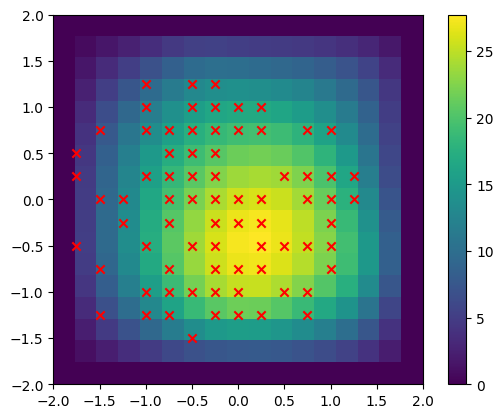

In [19]:
x, y =obs_points.T
plt.scatter(x,y, c='r', marker='x',)
im=plt.imshow(y_data[90].reshape(n_x,n_y), extent=(a, b, c, d))
plt.colorbar(im)

In [25]:
observed_data = y_data_norm[:, obs_indices]
observed_data.shape

(500, 75)

In [17]:
# Save the observed oint to a text file
#np.savetxt('./test_data/observed_data_nref4_75.txt', observed_data)
#np.savetxt('./test_data/observed_points_nref4_75.txt', obs_points)

# Load the data
observed_data = np.loadtxt('./test_data/observed_data_nref4_75.txt')
obs_points = np.loadtxt('./test_data/observed_points_nref4_75.txt')

# Noise

In [18]:
# Add noise
O = obs_points.shape[0]
noise_mean = np.zeros(O)

#diagonal of noise covariance
sigma = 0.05
noise_cov = sigma*np.ones(O)

# TODO add noise to the observation
noise = np.random.multivariate_normal(noise_mean, np.diag(noise_cov), size = 500)

In [20]:
# ADDING NOISE - NEW!
observed_data = observed_data + noise
observed_data

array([[-0.69660009,  0.1258044 ,  0.62361373, ...,  0.4596383 ,
        -0.13929556,  0.43617689],
       [-0.79742233, -0.03890151, -0.05091803, ..., -0.04059738,
         0.36811251,  0.15034688],
       [-0.33641336,  0.26305389, -0.04714208, ..., -0.06298707,
        -0.33045874,  0.4397853 ],
       ...,
       [-0.60907657,  0.03941958,  0.3034207 , ...,  0.53572978,
        -0.14595242,  0.14117863],
       [-0.87260976, -0.10852253, -0.03523841, ...,  0.82176751,
        -0.11019996,  0.15076432],
       [-0.86119096,  0.2110002 ,  0.47498926, ...,  0.66438443,
        -0.14632484,  0.48440451]])

## Dataset

Our dataset for the training is composed of 500 couples coefficient-observed solution. Each coefficient is a vector of 289 elements representing the real values of the PoI q over the 17x17 grid, each solution is a vector of 10 elements representing the values of the observable variable y in the 10 observation points.

(Remember: the final goal is to observe y and make estimates on q).

The dataset is split in train/test with a proprtion 80/20, then is batched in batches of 20 elements


In [21]:
# Split train/test set
obs_train, obs_test = train_test_split(observed_data, test_size=0.2, shuffle=False)
coeff_train, coeff_test = train_test_split(q_data, test_size=0.2, shuffle=False)

In [22]:
obs_train = tf.cast(obs_train, dtype=tf.float64)
obs_test = tf.cast(obs_test, dtype=tf.float64)
coeff_train = tf.cast(coeff_train, dtype=tf.float64)
coeff_test = tf.cast(coeff_test, dtype=tf.float64)

In [371]:
obs_train.shape

TensorShape([400, 17])

In [23]:
# Convert in tf Dataset
obs_train_data = tf.data.Dataset.from_tensor_slices(obs_train)
obs_test_data = tf.data.Dataset.from_tensor_slices(obs_test)

q_train_data = tf.data.Dataset.from_tensor_slices(coeff_train)
q_test_data = tf.data.Dataset.from_tensor_slices(coeff_test)

In [291]:
obs_train_data.element_spec #return the spec of a single "row" of the dataset
# observed data was sampled tocontain only 10 data point of the solution uh, so the sshape is (10,) -> ok

TensorSpec(shape=(17,), dtype=tf.float64, name=None)

In [292]:
q_train_data.element_spec

TensorSpec(shape=(81,), dtype=tf.float64, name=None)

In [24]:
# Batch the data
batch_size = 20

obs_train_data_batched = obs_train_data.batch(batch_size)
obs_test_data_batched = obs_test_data.batch(batch_size)

In [25]:
# Zip the datasets together
train_data_zipped = tf.data.Dataset.zip((obs_train_data, q_train_data))
test_data_zipped = tf.data.Dataset.zip((obs_test_data, q_test_data))

# Batch the zipped datasets
train_data_batched = train_data_zipped.batch(batch_size)
test_data_batched = test_data_zipped.batch(batch_size)

In [158]:
obs_train_data_batched.element_spec

TensorSpec(shape=(None, 10), dtype=tf.float64, name=None)

In [26]:
for i in obs_train_data_batched:
    print(i.numpy().shape)

(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)
(20, 75)


## Vae architecture

Here we implemented the variational autoencoder:
The Encoder network $\Psi$ has:
- 5 hidden layer with 500 units with ReLU activation function  
- an input layer with $O$ number of nodes to match the dimension of our observational data $\textbf{y}$
- an output layer with dimension $2D$ to match the estimate posterior mean $\mu_{post}$ and the diagonal of the posterior covariance $\Gamma_{post}$.  

The decoder network $\Psi_d$ has
- 2 hidden layer with 500 nodes and relu activation function  
- an input layer with $D$ number of nodes to represent a draw from the learned posterior
- an output layer with $O$ nodes to match the dimension of the observational data.
  
For both encoder and decoder no activation function is used in the output layer.

In [27]:
tf.keras.backend.set_floatx('float64') 

In [28]:
class VAE(tf.keras.Model):
    def __init__(self, input_dim, output_dim, latent_dim, n_units):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(input_dim, )),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units=latent_dim + latent_dim)  # No activation function in this layer
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(latent_dim,)),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units = n_units, activation="relu"),
                tf.keras.layers.Dense(units = output_dim),
            ]
        )

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        eps = tf.cast(eps, dtype=tf.float64) #RR
        u_draw = eps * tf.exp(logvar * .5) + mean # return u_draw assumiing diagonal cov matrix
        return u_draw

    def decode(self, z, apply_sigmoid=False): #sigmoid give us a probability distribution over the output
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

## Loss function

The loss function implemented below is the one described in the article:
$$
\frac{1}{M} \sum_{m=1}^M \frac{1-\alpha}{\alpha} (\log |\Gamma_{post}^{(m)}| + \lVert \mu_{post}^{(m)}- \textbf{u}^{(m)}) \rVert_{\Gamma_{post}^{(m)-1}}^2
$$

$$
    + \lVert \textbf{y}^{(m)} - F(\textbf{u}_{draw}^{(m)}(\textbf{W})) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2
$$

$$
     + \text{tr}(\Gamma_{pr}^{-1}\Gamma_{post}^{(m)}) +   \lVert \mu_{post}^{(m)}- \mu_{(pr)}) \rVert_{\Gamma_{pr}^{-1}}^2 + \log \frac{\Gamma_{pr}}{\Gamma_{post}^{(m)}}
$$
!!Chiedere del secondo termine

The loss function takes as input a batch of 20 vectors of 289 elements (20 predictions of q based on 20 inputs y) and computes for each of them the loss with regard to the real coefficients q. The total loss of the batch will be the mean of the 20 losses.

In [29]:
def compute_square_matrix_norm(diag_inv_cov, x):
    return tf.reduce_sum(x * diag_inv_cov * x, axis=-1)

def compute_inverse_matrix_norm(A, x):
    # returns the square of the norm A^-1, i.e. x' * A^-1 * x
    norm = [0] * int(x.shape[0])
    i = 0
    for xi in x:
        #serve reshape per xi, vogliamo vettore colonna
        xi = tf.reshape(xi, (-1,1))
        zi = tf.constant(tf.linalg.solve(A, xi))
        norm[i] = tf.reduce_sum(xi * zi)
        i = i+1
    norm = tf.convert_to_tensor(norm, dtype=tf.float64)
    return norm

def compute_loss(model, x, noise_cov, noise_mean, Cov, mean, alpha):
    mean_post, logvar = model.encode(x)  # post mean and log diagonal of the post covariance
    u_draw = model.reparameterize(mean_post, logvar)
    x_pred = model.decode(u_draw)

    # First term: ((1-alpha)/alpha) * (log |Γ_post| + ||μ_post - u_draw||_{Γ_post^-1}^2)
    det_logvar = tf.reduce_sum(logvar, axis=-1)  # log |Γ_post|
    inv_logvar = tf.exp(-logvar)  # Γ_post^-1 (diagonal)
    norm_post = compute_square_matrix_norm(inv_logvar, mean_post - u_draw)
    det_logvar = tf.cast(det_logvar, dtype=tf.float64)
    norm_post = tf.cast(norm_post, dtype=tf.float64)
    #first_term = ((1 - alpha) / alpha) * (det_logvar + norm_post)

    # Second term: ||y - F(u_draw) - μ_E||_{Γ_E^-1}^2
    inv_noise_cov = tf.math.reciprocal(noise_cov)  # Element-wise reciprocal for diagonal matrix
    x = tf.cast(x, dtype=tf.float64)
    x_pred = tf.cast(x_pred, dtype=tf.float64)
    second_term = compute_square_matrix_norm(inv_noise_cov, x - x_pred - noise_mean)

    # Third term: tr(Γ_pr^-1 Γ_post) 
    Var = tf.exp(logvar)
    i = 0
    trace_term = [0] * int(x.shape[0])
    for vi in Var:
        trace_term[i] = tf.linalg.trace(tf.linalg.solve(Cov, tf.linalg.diag(vi)))
        i = i+1
    trace_term = tf.convert_to_tensor(trace_term, dtype=tf.float64)    

    # Fourth term: ||μ_post - μ_{pr}||_{Γ_pr^-1}^2
    norm_prior = compute_inverse_matrix_norm(Cov, mean_post - mean)

    # Fifth term: log |Γ_pr| - log |Γ_post| TODO sbagliata
    #det_prior = tf.reduce_sum(tf.math.log(Cov)) 
    #det_prior = tf.cast(det_prior, dtype=tf.float64)
    #fifth_term = det_prior - det_logvar
    #fifth_term = - det_logvar

    # accorpamaneto primo e quinto termini per motivi numerici
    first_term = ((1 - 2*alpha) / alpha) * (det_logvar)  + ((1 - alpha) / alpha) * (norm_post)

    loss = tf.reduce_mean(first_term + second_term + trace_term + norm_prior) 
    return loss

## Metric function

Here we define the metric function, used to evaluate the model after every epoch. The function used is the averaged relative error:

$$
 \frac{1}{L} \sum_{l=1}^L \frac{\lVert \mathbf{y}^{(l)} - \Psi_d(\boldsymbol{\mu}_{\text{post}}(\mathbf{y}^{(l)})) \rVert_2^2}{\lVert  \mathbf{y}^{(l)}\rVert_2^2}
$$
where $\boldsymbol{\mu}_{\text{post}}(\mathbf{y}^{(l)})$ is the estimated posterior mean fron the encoder network $\Psi$ taking a datapoint $\mathbf{y}^{(l)}$ as input.

In [30]:
#TODO: seconda custom metric sui coefficenti
# TODO. controllar la metric nella scala originale, non normalizzata
# Define the custom metric function
def custom_metric(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)
    # Calculate the numerator: squared L2 norm of the difference
    numerator = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1) # Every batch have shape (4,289), so with axis = -1 we are summing over the row of 289 element

    # Calculate the denominator: squared L2 norm of y_true
    denominator = tf.reduce_sum(tf.square(y_true), axis=-1)

    # Calculate the fraction for each element in the batch
    fraction = numerator / denominator

    # Average the fractions over the batch
    return tf.reduce_mean(fraction)

In [31]:
def evaluate_model(model, test_data, noise_cov, noise_mean, Cov, mean, alpha):
    """
    Evaluates the model on test data and computes the custom metric.
    """
    total_metric = 0
    num_batches = 0
    validation_loss = 0

    for batch in test_data:
        x_test = batch
        mean, logvar = model.encode(x_test)
        z = model.reparameterize(mean, logvar)
        x_reconstructed = model.decode(z)

        # Compute custom metric
        metric_value = custom_metric(x_test, x_reconstructed)
        total_metric += metric_value
        num_batches += 1

        # Compute validation loss
        validation_loss += compute_loss(model, batch, noise_cov, noise_mean, Cov, mean, alpha)

    average_metric = total_metric / num_batches
    validation_loss = validation_loss / num_batches
    return validation_loss, average_metric

# TODO: vedi loss su traning e test set e valuta overfitting
# più epoche
# early stopping + restore weights

# Training and Evaluation

We train and evaluate the model with 20 epochs
!! La metric migliora per le prime 5/6 epochs poi si stabilizza subito. è normale?

In [32]:
def train_step(model, x, optimizer, noise_cov, noise_mean, Cov, mean, alpha):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, noise_cov, noise_mean, Cov, mean, alpha)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss  # Return the loss value

In [33]:
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 100
n_units = 500
alpha = 0.5
model = VAE(O, O, D, n_units)

# Initialize lists to store the training loss and validation loss for each epoch
train_losses = []
validation_losses = []

for epoch in range(epochs):
    start_time = time.time()

    num_of_batch = 0
    # Training
    for batch in obs_train_data_batched:
        loss = train_step(model, batch, optimizer, noise_cov, noise_mean, Cov, mean, alpha)
        num_of_batch += 1

    # Average training loss for the epoch
    train_losses.append(loss.numpy())

    # Evaluation
    validation_loss, test_metric = evaluate_model(model, obs_test_data_batched, noise_cov, noise_mean, Cov, mean, alpha)
    
    # Append validation loss
    validation_losses.append(validation_loss.numpy())

    end_time = time.time()
    print(f"Epoch {epoch + 1}, Time: {end_time - start_time:.2f}s, Train Loss: {loss.numpy():.4f}, Validation Loss: {validation_loss.numpy():.4f},Test Custom Metric: {test_metric.numpy():.4f}")



Epoch 1, Time: 9.56s, Train Loss: 9317678301968.6758, Validation Loss: 9130342468246.0039,Test Custom Metric: 1.2375
Epoch 2, Time: 9.43s, Train Loss: 2213563926831.1045, Validation Loss: 1915716233665.4624,Test Custom Metric: 0.7989
Epoch 3, Time: 9.34s, Train Loss: 188395882450.9716, Validation Loss: 107279509407.0040,Test Custom Metric: 0.4057
Epoch 4, Time: 9.41s, Train Loss: 91756620092.3732, Validation Loss: 38496372090.4275,Test Custom Metric: 0.3710
Epoch 5, Time: 9.85s, Train Loss: 65578438483.9419, Validation Loss: 26658000883.7341,Test Custom Metric: 0.3667
Epoch 6, Time: 9.24s, Train Loss: 53902720291.4137, Validation Loss: 20714639595.0508,Test Custom Metric: 0.3634
Epoch 7, Time: 9.10s, Train Loss: 44564220338.8436, Validation Loss: 16824715145.8568,Test Custom Metric: 0.3609
Epoch 8, Time: 9.02s, Train Loss: 34748616772.7739, Validation Loss: 14108695382.5458,Test Custom Metric: 0.3613
Epoch 9, Time: 9.06s, Train Loss: 49775697506.9783, Validation Loss: 11853987083.4848,

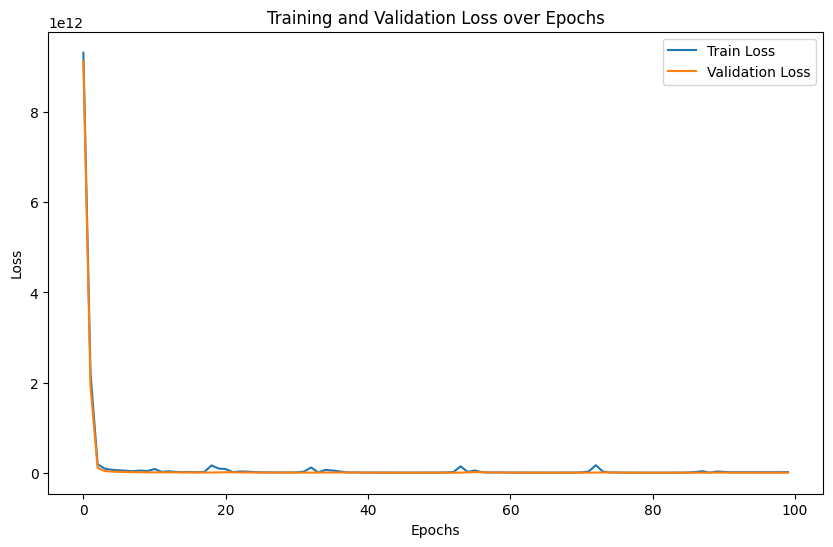

In [34]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

# Results

We try our model on the test dataset and plot some pictures in order to evaluate it

In [35]:
# Use as_numpy_iterator().next() to get a couple
train_batch = train_data_batched.as_numpy_iterator().next()
test_batch = test_data_batched.as_numpy_iterator().next()

!! Ha senso batchare il dataset test?

In [48]:
test_batch

(array([[-0.64845755,  0.31573545,  0.42386447, ...,  0.36760325,
         -0.57427442,  0.49287814],
        [-0.68159119, -0.28241059,  0.0519967 , ...,  0.32373755,
          0.13101035,  0.46814267],
        [-0.62105388, -0.13478582,  0.09134376, ...,  0.17525699,
          0.0825834 ,  0.51413557],
        ...,
        [-0.53453913, -0.27356601,  0.01653627, ...,  0.34632404,
          0.15962715,  0.23615495],
        [-0.29893665,  0.3064018 ,  0.24846541, ...,  0.37883256,
          0.16941915,  0.64036573],
        [-0.20959289, -0.15276132, -0.30973757, ...,  0.35060728,
          0.11852632,  0.4522648 ]]),
 array([[1.63022834, 1.684582  , 1.85677898, ..., 1.62026905, 1.46823503,
         1.24946368],
        [2.53685908, 2.46952797, 2.36992621, ..., 2.19944205, 1.94115902,
         1.88773531],
        [2.10313492, 1.96095388, 1.99715204, ..., 1.96068976, 1.61085977,
         1.43120554],
        ...,
        [2.83805713, 2.68323351, 2.32282763, ..., 2.30613304, 2.49974575

In [36]:
mean_post, log_cov_post = model.encode(test_batch[0])
cov_post = tf.exp(log_cov_post)

In [50]:
mean_post.numpy()

array([[-1.54140838,  3.09069745,  1.45986326, ..., -2.07890463,
        -1.6689383 ,  0.73095183],
       [-1.38133025,  2.78880728,  1.30222693, ..., -1.85775278,
        -1.59133978,  0.64841591],
       [-1.09712954,  2.18204899,  1.05844887, ..., -1.50232369,
        -1.23500289,  0.52859022],
       ...,
       [-1.28760641,  2.70870575,  1.31726191, ..., -1.82317101,
        -1.51806333,  0.64663774],
       [-1.51388939,  3.07410292,  1.45570304, ..., -2.06954391,
        -1.70652997,  0.77682251],
       [-1.56917946,  3.20039215,  1.54539023, ..., -2.17421071,
        -1.77024909,  0.81845793]])

In [51]:
mean_post.numpy().shape

(20, 289)

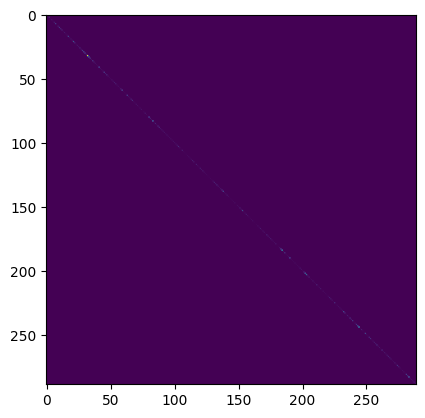

In [37]:
plt.imshow(np.diag(cov_post.numpy()[0])) # Ricordarsi che la Γ_post è la diagonale della matrice di convarianza(che è assunta diagonale)

In [53]:
cov_post[0]

<tf.Tensor: shape=(289,), dtype=float64, numpy=
array([2.35431936e-05, 9.36538250e-05, 4.10756167e-05, 1.59233248e-04,
       8.40682243e-05, 1.08535527e-04, 2.17715198e-04, 3.95474602e-05,
       3.07412309e-05, 4.04201043e-04, 5.30739224e-05, 6.79233574e-05,
       6.54899552e-05, 5.86462722e-05, 8.37581994e-05, 4.71921269e-05,
       1.73853759e-05, 9.21704871e-04, 1.81297722e-04, 1.79949320e-05,
       4.13476161e-05, 3.13791581e-04, 8.43959107e-05, 1.00887166e-04,
       1.00744032e-04, 3.03606894e-05, 2.91409360e-05, 4.37328587e-05,
       1.82849741e-04, 1.60551837e-04, 4.33851025e-05, 8.36914516e-05,
       2.50342995e-05, 2.26063576e-04, 6.82110597e-05, 2.07496250e-04,
       4.41864682e-05, 1.62128461e-05, 5.35729489e-05, 5.48807440e-05,
       8.30199961e-05, 4.15086772e-05, 2.87096319e-04, 4.92549997e-05,
       1.95758678e-05, 1.00340991e-04, 2.06749524e-05, 8.14331017e-05,
       3.17437750e-05, 1.40584899e-04, 5.56337997e-05, 3.52842434e-05,
       7.87903967e-05, 1.4990

In [38]:
q_draw = model.reparameterize(mean_post, cov_post)

In [191]:
q_draw.shape

TensorShape([20, 289])

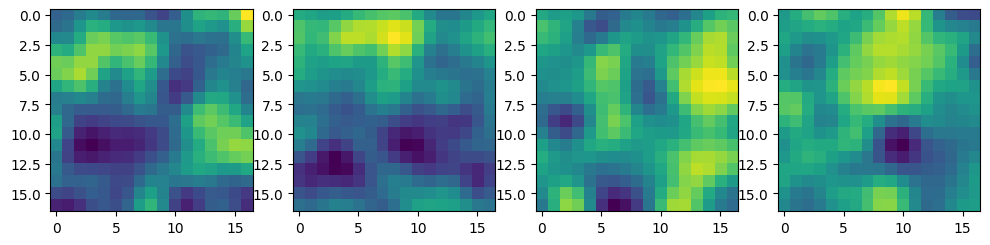

In [39]:
q_true = test_batch[1]

fig, axs = plt.subplots(1,4, figsize=(12, 6))
axs[0].imshow(q_true[0].reshape(n_x,n_y))
axs[1].imshow(q_true[1].reshape(n_x,n_y))
axs[2].imshow(q_true[2].reshape(n_x,n_y))
axs[3].imshow(q_true[3].reshape(n_x,n_y))

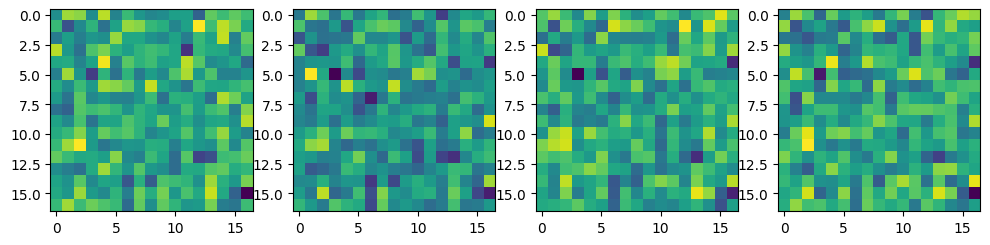

In [56]:
q_pred = q_draw.numpy()

fig, axs = plt.subplots(1,4, figsize=(12, 6))
axs[0].imshow(q_pred[0].reshape(n_x,n_y))
axs[1].imshow(q_pred[1].reshape(n_x,n_y))
axs[2].imshow(q_pred[2].reshape(n_x,n_y))
axs[3].imshow(q_pred[3].reshape(n_x,n_y))

In [40]:
it = 100
q_draws = []

for i in np.arange(it):
    q_draw = model.reparameterize(mean_post, cov_post)
    q_draws.append(q_draw)

q_draws = np.array(q_draws)
mean_q_draw = np.mean(q_draws, axis=0)
var_q_draw = np.var(q_draws, axis=0)
std_q_draw = np.std(q_draws, axis=0)

lower_bound = np.percentile(q_draws, 2.5, axis=0)
upper_bound = np.percentile(q_draws, 97.5, axis=0)
credibility_interval = (lower_bound, upper_bound)

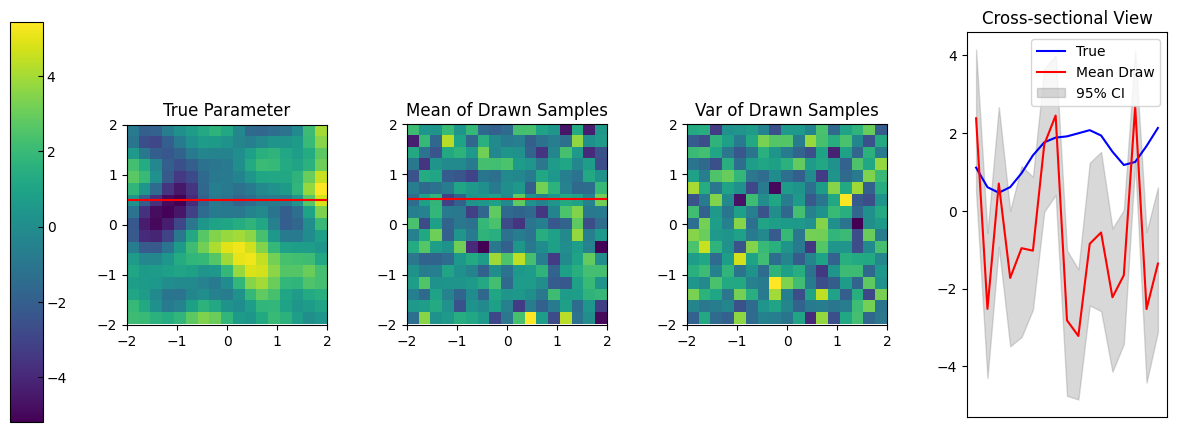

In [61]:
fig, axs = plt.subplots(1, 4, figsize=(13, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

ii = 12

vmin = min(np.min(q_true), np.min(mean_post.numpy()), np.min(var_q_draw))
vmax = max(np.max(q_true), np.max(mean_post.numpy()), np.max(var_q_draw))

cbar_ax = fig.add_axes([0.01, 0.1, 0.025, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=10, direction='in', pad=3) 
cbar.ax.yaxis.set_label_position('left') 

im0 = axs[0].imshow(q_true[ii].reshape(n_x, n_y), extent=(a, b, c, d))
axs[0].axhline(y=0.5, color='r', linestyle='-')
axs[0].set_title("True Parameter")

im1 = axs[1].imshow(mean_post.numpy()[ii].reshape(n_x, n_y), extent=(a, b, c, d))
axs[1].axhline(y=0.5, color='r', linestyle='-')
axs[1].set_title("Mean of Drawn Samples")

im2 = axs[2].imshow(var_q_draw[ii].reshape(n_x, n_y), extent=(a, b, c, d))
axs[2].set_title("Var of Drawn Samples")

# Cross-sectional view
cross_section_index = 8  # Index corresponding to the line y = 0.5
q_true_cross_section = q_true[ii].reshape(n_x, n_y)[cross_section_index, :]
mean_q_draw_cross_section = mean_q_draw[ii].reshape(n_x, n_y)[cross_section_index, :]

# Extract the lower and upper bounds of the credibility interval for the cross-section
lower_bound_cross_section = credibility_interval[0][ii].reshape(n_x, n_y)[cross_section_index, :]
upper_bound_cross_section = credibility_interval[1][ii].reshape(n_x, n_y)[cross_section_index, :]

axs[3].plot(q_true_cross_section, color="blue", label="True")
axs[3].plot(mean_q_draw_cross_section, color="red", label="Mean Draw")
axs[3].fill_between(np.arange(n_x), lower_bound_cross_section, upper_bound_cross_section, color='gray', alpha=0.3, label="95% CI")
axs[3].set_title("Cross-sectional View")
axs[3].legend()
axs[3].set_xticks([])

#plt.savefig('./test_figures/test5figures/q_reconstruction')
# Display the plot
fig.subplots_adjust(left=0.1, right=0.9, wspace=0.4)
plt.show()

In [66]:
y_pred = model.decode(q_draw)
y_pred = y_pred * scaling_factor_y

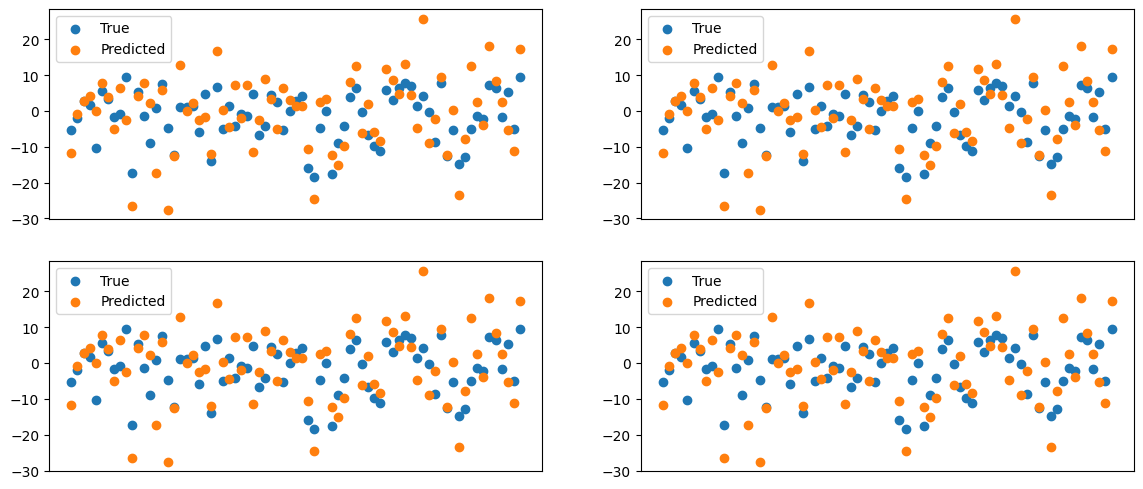

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(14, 6))
y_true = test_batch[0] * scaling_factor_y

# Plotting each subplot
#axs[0, 0].plot(y_true[11], label="True")
#axs[0, 0].plot(y_pred[11], label="Predicted")
#axs[0, 0].legend()
#axs[0, 0].set_xticks([])
#axs[0, 0].set_xticklabels([])
axs[0, 0].scatter(range(len(y_true[11])), y_true[1], label="True")
axs[0, 0].scatter(range(len(y_pred[11])), y_pred[1], label="Predicted")
axs[0, 0].legend()
axs[0, 0].set_xticks([])
axs[0, 0].set_xticklabels([])

#axs[0, 1].plot(y_true[1], label="True")
#axs[0, 1].plot(y_pred[1], label="Predicted")
#axs[0, 1].legend()
#axs[0, 1].set_xticks([])
#axs[0, 1].set_xticklabels([])
axs[0, 1].scatter(range(len(y_true[1])), y_true[1], label="True")
axs[0, 1].scatter(range(len(y_pred[1])), y_pred[1], label="Predicted")
axs[0, 1].legend()
axs[0, 1].set_xticks([])
axs[0, 1].set_xticklabels([])

#axs[1, 0].plot(y_true[6], label="True")
#axs[1, 0].plot(y_pred[6], label="Predicted")
#axs[1, 0].legend()
#axs[1, 0].set_xticks([])
#axs[1, 0].set_xticklabels([])
axs[1, 0].scatter(range(len(y_true[5])), y_true[1], label="True")
axs[1, 0].scatter(range(len(y_pred[5])), y_pred[1], label="Predicted")
axs[1, 0].legend()
axs[1, 0].set_xticks([])
axs[1, 0].set_xticklabels([])

#axs[1, 1].plot(y_true[3], label="True")
#axs[1, 1].plot(y_pred[3], label="Predicted")
#axs[1, 1].legend()
#axs[1, 1].set_xticks([])
#axs[1, 1].set_xticklabels([])
axs[1, 1].scatter(range(len(y_true[3])), y_true[1], label="True")
axs[1, 1].scatter(range(len(y_pred[3])), y_pred[1], label="Predicted")
axs[1, 1].legend()
axs[1, 1].set_xticks([])
axs[1, 1].set_xticklabels([])

#plt.savefig('./test_figures/test5figures/y_reconstruction.png')
plt.show()